In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
batch_size = 512

train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)

total_train_size = len(train_dataset)

validation_split = 0.2
train_split = int(total_train_size * (1 - validation_split))
val_split = total_train_size - train_split

train_subset, val_subset = random_split(train_dataset, [train_split, val_split])

train_loader = torch.utils.data.DataLoader(
    train_subset, batch_size=batch_size, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_subset, batch_size=batch_size, shuffle=False
)

test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
def clip_weights(model, min_val, max_val):
    with torch.no_grad():
        for param in model.parameters():
            param.clamp_(min_val, max_val)

In [ ]:
model1 = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):

    model1.train()
    train_loss = 0

    for img, _ in train_loader:
        img = img.to(device)
        optimizer.zero_grad()
        output = model1(img.view(-1, 3, 32, 32))
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
        clip_weights(model1, -0.5, 0.5)
        train_loss += loss.item() * img.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    model1.eval()
    val_loss = 0
    with torch.no_grad():
        for img, _ in val_loader:
            img = img.to(device)
            output = model1(img.view(-1, 3, 32, 32))
            loss = criterion(output, img)
            val_loss += loss.item() * img.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

Epoch [1/100] | Train Loss: 0.055436 | Val Loss: 0.016182
Epoch [2/100] | Train Loss: 0.011655 | Val Loss: 0.009270
Epoch [3/100] | Train Loss: 0.007842 | Val Loss: 0.006977
Epoch [4/100] | Train Loss: 0.006112 | Val Loss: 0.005389
Epoch [5/100] | Train Loss: 0.005212 | Val Loss: 0.004800
Epoch [6/100] | Train Loss: 0.004605 | Val Loss: 0.005170
Epoch [7/100] | Train Loss: 0.004199 | Val Loss: 0.003672
Epoch [8/100] | Train Loss: 0.003745 | Val Loss: 0.003866
Epoch [9/100] | Train Loss: 0.003548 | Val Loss: 0.003299
Epoch [10/100] | Train Loss: 0.003246 | Val Loss: 0.003856
Epoch [11/100] | Train Loss: 0.003143 | Val Loss: 0.002768
Epoch [12/100] | Train Loss: 0.002910 | Val Loss: 0.002679
Epoch [13/100] | Train Loss: 0.002802 | Val Loss: 0.002460
Epoch [14/100] | Train Loss: 0.002886 | Val Loss: 0.002481
Epoch [15/100] | Train Loss: 0.002586 | Val Loss: 0.003035
Epoch [16/100] | Train Loss: 0.002676 | Val Loss: 0.002209
Epoch [17/100] | Train Loss: 0.002419 | Val Loss: 0.002547
Epoch 

In [ ]:
model2 = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
lambda_l1 = 0.001

num_epochs = 100
for epoch in range(num_epochs):
    model2.train()
    train_loss = 0

    for img, _ in train_loader:
        img = img.to(device)
        optimizer.zero_grad()

        output = model2(img.view(-1, 3, 32, 32))
        loss = criterion(output, img)

        l1_loss = sum(p.abs().sum() for p in model2.parameters())
        loss = loss + lambda_l1 * l1_loss

        loss.backward()
        optimizer.step()
        clip_weights(model2, -0.5, 0.5)

        train_loss += loss.item() * img.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    model2.eval()
    val_loss = 0
    with torch.no_grad():
        for img, _ in val_loader:
            img = img.to(device)
            output = model2(img.view(-1, 3, 32, 32))
            loss = criterion(output, img)

            l1_loss = sum(p.abs().sum() for p in model2.parameters())
            loss = loss + lambda_l1 * l1_loss

            val_loss += loss.item() * img.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

Epoch [1/100] | Train Loss: 1.077842 | Val Loss: 0.383685
Epoch [2/100] | Train Loss: 0.255096 | Val Loss: 0.213667
Epoch [3/100] | Train Loss: 0.196039 | Val Loss: 0.166209
Epoch [4/100] | Train Loss: 0.126348 | Val Loss: 0.112861
Epoch [5/100] | Train Loss: 0.095489 | Val Loss: 0.089805
Epoch [6/100] | Train Loss: 0.085365 | Val Loss: 0.085839
Epoch [7/100] | Train Loss: 0.082856 | Val Loss: 0.083547
Epoch [8/100] | Train Loss: 0.080841 | Val Loss: 0.085772
Epoch [9/100] | Train Loss: 0.077173 | Val Loss: 0.080080
Epoch [10/100] | Train Loss: 0.074028 | Val Loss: 0.074645
Epoch [11/100] | Train Loss: 0.072017 | Val Loss: 0.076086
Epoch [12/100] | Train Loss: 0.070893 | Val Loss: 0.072145
Epoch [13/100] | Train Loss: 0.070672 | Val Loss: 0.070061
Epoch [14/100] | Train Loss: 0.070605 | Val Loss: 0.071420
Epoch [15/100] | Train Loss: 0.070498 | Val Loss: 0.072167
Epoch [16/100] | Train Loss: 0.070764 | Val Loss: 0.071570
Epoch [17/100] | Train Loss: 0.070867 | Val Loss: 0.072934
Epoch 

In [ ]:
def psnr(mse):
    return -10 * np.log10(mse)

def evaluate_autoencoder(model, dataloader, criterion, device):
    model.eval()
    total_mse = 0
    num_images = 0
    all_originals = []
    all_reconstructions = []

    with torch.no_grad():
        for img, _ in dataloader:
            img = img.to(device)
            output = model(img)

            mse = criterion(output, img)
            total_mse += mse.item() * img.size(0)
            num_images += img.size(0)

            if len(all_originals) < 5:
                all_originals.append(img.cpu())
                all_reconstructions.append(output.cpu())

    avg_mse = total_mse / num_images
    psnr_value = psnr(avg_mse)

    print(f"Test MSE: {avg_mse:.6f}")
    print(f"PSNR: {psnr_value:.2f} dB")

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))

    for i in range(5):
        axes[0, i].imshow(np.transpose(all_originals[i][0], (1, 2, 0)))
        axes[0, i].axis('off')

        axes[1, i].imshow(np.transpose(all_reconstructions[i][0], (1, 2, 0)))
        axes[1, i].axis('off')

    axes[0, 0].set_title("Original Images")
    axes[1, 0].set_title("Reconstructed Images")

    plt.show()

    return avg_mse, psnr_value

Model 1: ReLU & DropOut & Adam (Weight Clipping):
Test MSE: 0.000746
PSNR: 31.28 dB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.019607842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9980636..0.043454535].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6392157..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6272505..0.6571171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9975983..0.7119958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].

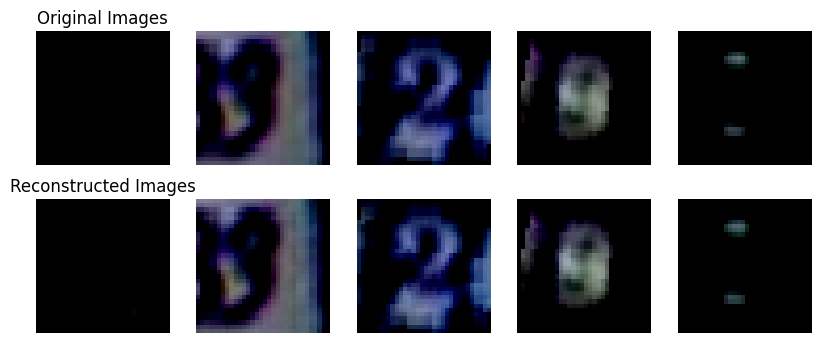

In [ ]:
print("Model 1: ReLU & DropOut & Adam (Weight Clipping):")
mse, psnr1 = evaluate_autoencoder(model1, test_loader, criterion, device)

Model 2: ReLU & DropOut & Adam (Weight Clipping + L1):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.019607842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9189492..-0.12386318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9614631..0.5725745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94023776..0.6450326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Clip

Test MSE: 0.014863
PSNR: 18.28 dB


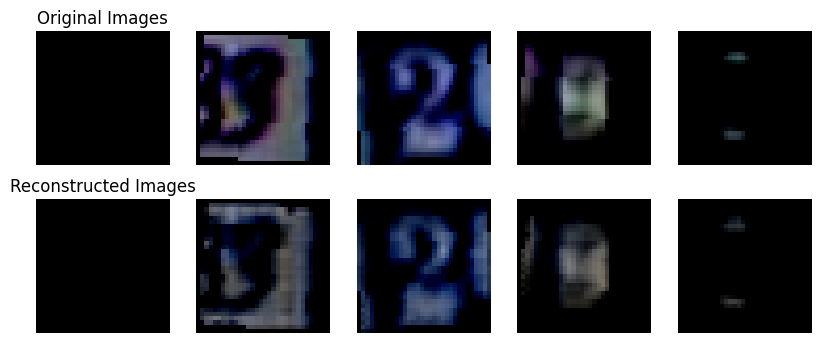

In [ ]:
print("Model 2: ReLU & DropOut & Adam (Weight Clipping + L1):")
mse, psnr2 = evaluate_autoencoder(model2, test_loader, criterion, device)

In [ ]:
class AutoencoderLeakyReLU(nn.Module):
    def __init__(self):
        super(AutoencoderLeakyReLU, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model3 = AutoencoderLeakyReLU().to(device)
optimizer = optim.RMSprop(model3.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model3.train()
    train_loss = 0

    for img, _ in train_loader:
        img = img.to(device)
        optimizer.zero_grad()

        output = model3(img.view(-1, 3, 32, 32))
        loss = criterion(output, img)

        loss.backward()
        optimizer.step()
        clip_weights(model3, -0.5, 0.5)

        train_loss += loss.item() * img.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    model3.eval()
    val_loss = 0
    with torch.no_grad():
        for img, _ in val_loader:
            img = img.to(device)
            output = model3(img.view(-1, 3, 32, 32))
            loss = criterion(output, img)
            val_loss += loss.item() * img.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

Epoch [1/100] | Train Loss: 0.035123 | Val Loss: 0.012957
Epoch [2/100] | Train Loss: 0.010974 | Val Loss: 0.009709
Epoch [3/100] | Train Loss: 0.008484 | Val Loss: 0.007974
Epoch [4/100] | Train Loss: 0.007125 | Val Loss: 0.007701
Epoch [5/100] | Train Loss: 0.006060 | Val Loss: 0.005441
Epoch [6/100] | Train Loss: 0.005495 | Val Loss: 0.005982
Epoch [7/100] | Train Loss: 0.004908 | Val Loss: 0.004827
Epoch [8/100] | Train Loss: 0.004507 | Val Loss: 0.004881
Epoch [9/100] | Train Loss: 0.004185 | Val Loss: 0.005146
Epoch [10/100] | Train Loss: 0.003949 | Val Loss: 0.003621
Epoch [11/100] | Train Loss: 0.003737 | Val Loss: 0.003311
Epoch [12/100] | Train Loss: 0.003526 | Val Loss: 0.003160
Epoch [13/100] | Train Loss: 0.003373 | Val Loss: 0.003988
Epoch [14/100] | Train Loss: 0.003198 | Val Loss: 0.003390
Epoch [15/100] | Train Loss: 0.003091 | Val Loss: 0.002863
Epoch [16/100] | Train Loss: 0.002925 | Val Loss: 0.003697
Epoch [17/100] | Train Loss: 0.002755 | Val Loss: 0.002917
Epoch 

Model 3: LeakyReLU & RMSProp (Weight Clipping + L1 Sparsity):


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.035294116].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99727863..0.048675902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99978465..0.62986696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9997964..0.6673035].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Cl

Test MSE: 0.000802
PSNR: 30.96 dB


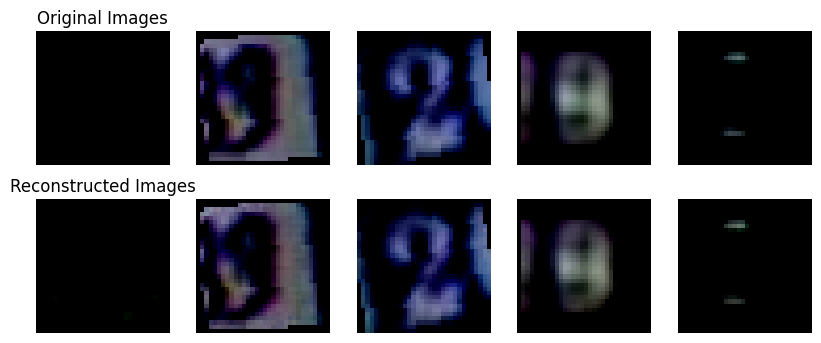

In [ ]:
print("Model 3: LeakyReLU & RMSProp (Weight Clipping + L1 Sparsity):")
mse, psnr3 = evaluate_autoencoder(model3, test_loader, criterion, device)

In [ ]:
print(f'PSNR for Model 1: ReLU & Adam (Weight Clipping): {psnr1:.2f} dB')
print(f'PSNR for Model 2: ReLU & Adam (Weight Clipping + L1): {psnr2:.2f} dB')
print(f'PSNR for Model 3: LeakyReLU & RMSProp (Weight Clipping + L1): {psnr3:.2f} dB')

PSNR for Model 1: ReLU & DropOut & Adam (Weight Clipping): 31.28 dB
PSNR for Model 2: ReLU & DropOut & Adam (Weight Clipping + L1): 18.28 dB
PSNR for Model 3: LeakyReLU & RMSProp (Weight Clipping + L1): 30.96 dB
